In [1]:
import torch
import torch.nn as nn

import time
import numpy as np
import skimage.color as color
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader
from torchvision import transforms as tf, datasets as ds
from torchvision.utils import make_grid

In [2]:
data_root_color = 'C:/DataSets/Celeba/sample'
data_root_grayscale = 'C:/DataSets/Celeba/grayscale'
workers = 0
batch_size = 10
image_size = 128
nc = 3  # Number of output color channels.
nz = 1  # Number of input color channels (Latent vector).
ngf = 64    # Depth of feature map, carried through the generator(G).
ndf = 64    # Depth of feature map, carried through the discriminator(D).
number_epochs = 5
lr = 2e-4
beta = 5e-1
ngpu = 1
weight_decay = 1e-1

In [3]:
is_cuda_available = torch.cuda.is_available()
device = torch.device('cuda:0' if is_cuda_available and ngpu > 0 else 'cpu')
device

device(type='cuda', index=0)

In [4]:
image_transform = {
    "rgb": tf.Compose([
        tf.Resize(image_size),
        tf.CenterCrop(image_size),
        tf.ToTensor()
        # tf.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ]),
    "gray": tf.Compose([
        tf.Resize(image_size),
        tf.CenterCrop(image_size),
        tf.ToTensor()
        # tf.Normalize(mean=[0.5], std=[0.5])
    ])
}

In [5]:
# Grayscale image dataset load.
gray_set = ds.ImageFolder(root=data_root_grayscale, transform=image_transform["gray"])

In [6]:
gray_loader = DataLoader(gray_set, batch_size, shuffle=True, num_workers=workers, pin_memory=is_cuda_available)

Text(0.5, 1.0, 'GRAYSCALE IMAGE SAMPLE')

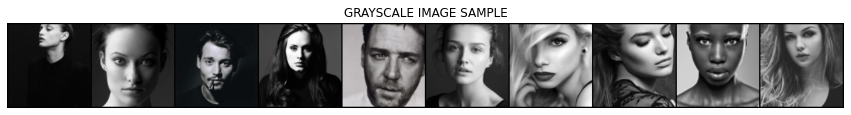

In [7]:
g_im = next(iter(gray_loader))

g_grid = make_grid(g_im[0], nrow=10, normalize=True)

plt.figure(figsize=(15, 14))
plt.imshow(np.transpose(g_grid, axes=(1, 2, 0)))
plt.axis('off')
plt.title('GRAYSCALE IMAGE SAMPLE')

In [8]:
color_set = ds.ImageFolder(root=data_root_color, transform=image_transform["rgb"])

In [9]:
color_loader = DataLoader(color_set, batch_size, shuffle=False, num_workers=workers, pin_memory=is_cuda_available)

Text(0.5, 1.0, 'COLOR IMAGE SAMPLE')

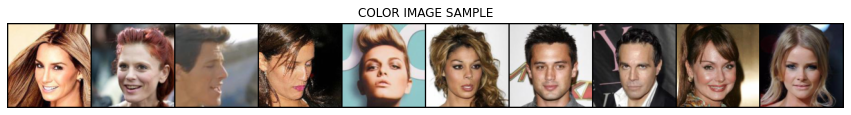

In [10]:
c_im = next(iter(color_loader))

c_grid = make_grid(c_im[0], nrow=10, normalize=True)

plt.figure(figsize=(15, 14))
plt.imshow(np.transpose(c_grid, axes=(1, 2, 0)))
plt.axis('off')
plt.title('COLOR IMAGE SAMPLE')

In [11]:
class RGB2LAB(object):

    def __call__(self, image):
        """
        :param image: PIL/NumPy image to be converted.
        :return: the LAB color channel image.
        """
        return color.rgb2lab(np.array(image))

class RGB2L(object):

    def __call__(self, image):
        """
        :param image: PIL/NumPy image to be converted.
        :return: the LAB color channel image.
        """
        return color.rgb2lab(np.array(image))[:, :, 0]


In [12]:
def lab2rgb(image, dim=None):
    """
    :param image is a single Lab image the shape of (X, y, 3)
    :param dim to define the color-channel dimension.
    """
    image = np.transpose(image, axes=(1, 2, 0))

    if dim is not None:
        z = np.zeros_like(image)
        if dim != 0:
            z[:, :, 0] = 80  # Increase the brightness to see other color channels(a & b).

        z[:, :, dim] = image[:, :, dim]
        return color.lab2rgb(z)
    else:
        return color.lab2rgb(image)

In [13]:
image_transform['lab'] = tf.Compose([
    tf.Resize(image_size),
    tf.CenterCrop(image_size),
    RGB2LAB(),
    tf.ToTensor()
    # tf.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

image_transform['l'] = tf.Compose([
    tf.Resize(image_size),
    tf.CenterCrop(image_size),
    RGB2L(),
    tf.ToTensor()
    # tf.Normalize(mean=[0.5], std=[0.5])
])

In [14]:
lab_set = ds.ImageFolder(root=data_root_color, transform=image_transform['lab'])
lab_loader = DataLoader(lab_set, batch_size, num_workers=workers, pin_memory=is_cuda_available)

In [15]:
l_set = ds.ImageFolder(root=data_root_color, transform=image_transform['l'])
l_loader = DataLoader(l_set, batch_size, num_workers=workers, pin_memory=is_cuda_available)

Text(0.5, 1.0, 'B CHANNEL SAMPLE')

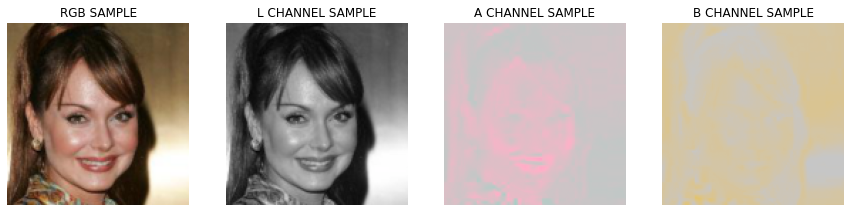

In [16]:
IMG_INDEX = 8

lab_im = next(iter(lab_loader))[0][IMG_INDEX]

plt.figure(figsize=(15, 14))

plt.subplot(141)
plt.imshow(np.transpose(c_im[0][IMG_INDEX], axes=(1, 2, 0)))
plt.axis('off')
plt.title('RGB SAMPLE')

plt.subplot(142)
plt.imshow(lab2rgb(lab_im, 0))
plt.axis('off')
plt.title('L CHANNEL SAMPLE')

plt.subplot(143)
plt.imshow(lab2rgb(lab_im, 1))
plt.axis('off')
plt.title('A CHANNEL SAMPLE')

plt.subplot(144)
plt.imshow(lab2rgb(lab_im, 2))
plt.axis('off')
plt.title('B CHANNEL SAMPLE')

In [17]:
l_im = next(iter(l_loader))

## Colorizing Images with Supervised Learning

In [20]:
class ColorNet(nn.Module):

    def __init__(self, in_channels=1, out_channels=3, n_layers=(32, 64, 64, 16, 4)):
        super(ColorNet, self).__init__()

        layers = []
        prev = in_channels

        for n in n_layers:
            layers.append(nn.Conv2d(in_channels=prev, out_channels=n, kernel_size=4, stride=2, padding=1)),
            layers.append(nn.BatchNorm2d(n)),
            layers.append(nn.ReLU())
            layers.append(nn.AvgPool2d(kernel_size=2, stride=2))
            layers.append(nn.Upsample(scale_factor=4.))
            prev = n

        layers.append(nn.Conv2d(in_channels=prev, out_channels=out_channels, kernel_size=3, stride=1, padding=1))

        self.main = nn.Sequential(*layers)

    def forward(self, x):
        return self.main(x)

colorNet = ColorNet().to(device).double()
colorNet

ColorNet(
  (main): Sequential(
    (0): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (4): Upsample(scale_factor=4.0, mode=nearest)
    (5): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU()
    (8): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (9): Upsample(scale_factor=4.0, mode=nearest)
    (10): Conv2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (11): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU()
    (13): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (14): Upsample(scale_factor=4.0, mode=nearest)
    (15): Conv2d(64, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (16): BatchNorm2d(16, eps=1e-

In [21]:
torch.cuda.empty_cache()

criterion = nn.MSELoss().to(device)
optimizer = torch.optim.Adam(colorNet.parameters(), lr=lr)

epochs = 5
losses = []

start = time.time()

for i in range(epochs):
    i += 1

    for batch, (X, y) in enumerate(zip(l_loader, lab_loader)):
        batch += 1

        X = X[0].to(device)
        y = y[0].to(device)

        y_pred = colorNet(X)
        loss = criterion(y_pred, y)

        if batch == 1 or batch % 100 == 0:
            losses.append(loss)
            print(f'Epoch: {i}/{epochs}, Batch: {batch}/{len(l_loader)} => Loss: {loss}')


        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    duration = time.time() - start
    print(f'Duration to execute: {duration / 60:0.4f} minutes')

Epoch: 1/5, Batch: 1/2560 => Loss: 1187.8810364788483
Epoch: 1/5, Batch: 100/2560 => Loss: 1189.1539517385218
Epoch: 1/5, Batch: 200/2560 => Loss: 1073.2076175243783
Epoch: 1/5, Batch: 300/2560 => Loss: 1292.3288038834078
Epoch: 1/5, Batch: 400/2560 => Loss: 1013.559096486992
Epoch: 1/5, Batch: 500/2560 => Loss: 944.6994507684368
Epoch: 1/5, Batch: 600/2560 => Loss: 914.8778743158352
Epoch: 1/5, Batch: 700/2560 => Loss: 997.1658155730894
Epoch: 1/5, Batch: 800/2560 => Loss: 880.0741027561664
Epoch: 1/5, Batch: 900/2560 => Loss: 943.90310733578
Epoch: 1/5, Batch: 1000/2560 => Loss: 925.4400402641809
Epoch: 1/5, Batch: 1100/2560 => Loss: 587.3658036347946
Epoch: 1/5, Batch: 1200/2560 => Loss: 800.2929590919283
Epoch: 1/5, Batch: 1300/2560 => Loss: 616.264063101445
Epoch: 1/5, Batch: 1400/2560 => Loss: 736.2173435766791
Epoch: 1/5, Batch: 1500/2560 => Loss: 745.5968722510228
Epoch: 1/5, Batch: 1600/2560 => Loss: 764.1964791844317
Epoch: 1/5, Batch: 1700/2560 => Loss: 437.70706425323107
Ep

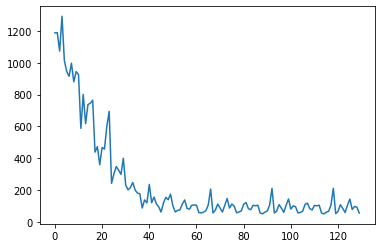

In [22]:
plt.plot(losses)

In [23]:
@torch.no_grad()
def view(image):

    colorNet.eval()

    image = colorNet(image.to(device))
    print(image.shape)

    image = lab2rgb(image.cpu().numpy().reshape(-1, 128, 128))

    return image

torch.Size([1, 3, 128, 128])


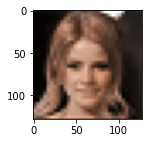

In [31]:
image = l_im[0][9]
image = view(image.view(-1, 1, 128, 128).double())

plt.figure(figsize=(3, 2))
plt.imshow(image)